In [1080]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [1081]:
label_path = './data/data_by_table/pre_24h_data_v3.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'
raw_data_path = './data/data_by_table/pre_24_merged_30_rows_12_07.csv'

data_df = pd.read_csv(label_path)
flag_data_df = pd.read_csv(flag_data_path)
label_df = pd.read_csv(label_path)
data_df['BMI'] = data_df['weight_kg'] / ((data_df['height_cm'] / 100) ** 2)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])
data_df = data_df.drop(columns=['height_cm', 'weight_kg'])
data_df['RSBI'] =  data_df['tidal_volume_observed'] / data_df['resp_rate']
data_df['minute_ventilation'] = data_df['tidal_volume_observed'] * data_df['resp_rate']
print(data_df.columns)
print(data_df['charttime'])
TVF_model = tf.keras.models.load_model('my_model.h5')

Index(['Unnamed: 0', 'charttime', 'stay_id', 'O2_flow', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',
       'first_careunit', 'tobacco', 'label', 'Rev_h', 'dod_h', 'BMI', 'RSBI',
       'minute_ventilation'],
      dtype='object')
0        2144-01-11 20:00:00
1        2144-01-11 21:00:00
2        2144-01-11 22:00:00
3        2144-01-11 23:00:00
4        2144-01-12 00:00:00
                ...         
68155    2124-08-21 05:00:00
68156    2124-08-21 06:00:00
68157    2124-08-21 07:00:00
68158    2124-08-21 08:00:00
68159    2124-08-21 09:00:00
Name: charttime, Length: 68160, dtype: object


In [1082]:
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 

In [1167]:
def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = 48
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = -(48 - id_df['Rev_h'].iloc[0])
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = -(96 - id_df['dod_h'].iloc[0]*2)
                else:
                    label = -96 
    return label

In [907]:
def lstm_data(flag_data_df, data_df):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            id_df = id_df.drop(columns='dod_h')
            total_x.append(id_df.values)
            total_y.append(label)

    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y

In [1209]:
aug_columns = ['spo2','peep','heart_rate','respiratory_rate_set','plateau_pressure','tidal_volume_observed','fio2','O2_flow','sbp','dbp','mbp','resp_rate','RSBI','minute_ventilation']

def NN_data(flag_data_df, data_df,label_df,  hour = 23):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        id_df_label = label_df[label_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df_label)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            #id_df = id_df.drop(columns='dod_h')

            
            zero_hr_values = id_df.iloc[hour, :].values
            zero_hr_values = generate_more_feature(id_df, aug_columns ,zero_hr_values)

            #zero_hr_values = np.append(zero_hr_values,  get_TVF_diff(id_df))
            total_x.append(zero_hr_values)
            total_y.append(label)
    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y
        

In [418]:
lstm_x, lstm_y = lstm_data(flag_data_df, data_df)

In [249]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def train_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch):

    # Define model and train
    def build_lstm_model(timesteps, num_features):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=(timesteps, num_features)),
            tf.keras.layers.Dense(1) 
        ])
        model.build(input_shape=(None, timesteps, num_features))
        return model

    model = build_lstm_model(timesteps=X_train.shape[1], num_features=X_train.shape[2])

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))
    return model



In [1178]:
total_x, total_y = NN_data(flag_data_df, data_df,label_df)

In [1210]:
# total_x = lstm_x
# total_y = lstm_y
total_x = total_x.astype(np.float32)
total_y = total_y.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
# Handle NaN values by replacing them with zeros (you can choose a different strategy)
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)

X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2, random_state=433432)#4277  433432
print(X_train.shape)
print(y_train.shape)
model = train_NN_module(X_train, y_train, X_test, y_test, epoch= 30, learning_rate=0.001, batch=32)

(1602, 124)
(1602, 1)
Epoch 1/30
51/51 [==============================] - 1s 18ms/step - loss: 2822.1528 - val_loss: 2978.9377
Epoch 2/30
51/51 [==============================] - 1s 10ms/step - loss: 2643.7346 - val_loss: 2705.9817
Epoch 3/30
51/51 [==============================] - 0s 5ms/step - loss: 2447.5725 - val_loss: 2468.1104
Epoch 4/30
51/51 [==============================] - 0s 5ms/step - loss: 2214.0430 - val_loss: 2361.5344
Epoch 5/30
51/51 [==============================] - 0s 6ms/step - loss: 2073.8655 - val_loss: 2084.2358
Epoch 6/30
51/51 [==============================] - 0s 5ms/step - loss: 2076.5767 - val_loss: 2082.5552
Epoch 7/30
51/51 [==============================] - 0s 5ms/step - loss: 1985.3174 - val_loss: 2062.7395
Epoch 8/30
51/51 [==============================] - 0s 7ms/step - loss: 2002.6707 - val_loss: 2042.8188
Epoch 9/30
51/51 [==============================] - 0s 6ms/step - loss: 1970.1152 - val_loss: 2031.9163
Epoch 10/30
51/51 [=====================

In [1211]:
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba >0 , 1, 0)
y_label = np.where(y_test > 0, 1, 0)
y_train_label = np.where(y_train > 0, 1, 0)

13/13 [==============================] - 0s 3ms/step


In [1212]:
def false_percentage(y_label):
    zero = len(y_label) - np.count_nonzero(y_label)
    print(f"false percentage: {(zero/len(y_label)) * 100:.2f}%")

In [1213]:
def calculate_tpr_tnr(y_true, y_pred):
    # 计算 TP, FN, TN, FP
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    # 计算 TPR 和 TNR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    return TPR, TNR

In [1214]:
accuracy = np.mean(y_pred == y_label)
tpr, tnr = calculate_tpr_tnr(y_label, y_pred)
print("TPR:", tpr)
print("TNR:", tnr)
print(f'Accuracy: {accuracy * 100:.2f}%')


TPR: [0.80769231]
TNR: [0.56737589]
Accuracy: 72.32%


In [1215]:
false_percentage(y_label)
false_percentage(y_pred)
false_percentage(y_train_label)

false percentage: 35.16%
false percentage: 32.42%
false percentage: 35.21%


AUROC: 0.7648663393344244
AUC-ROC: 0.7648663393344244


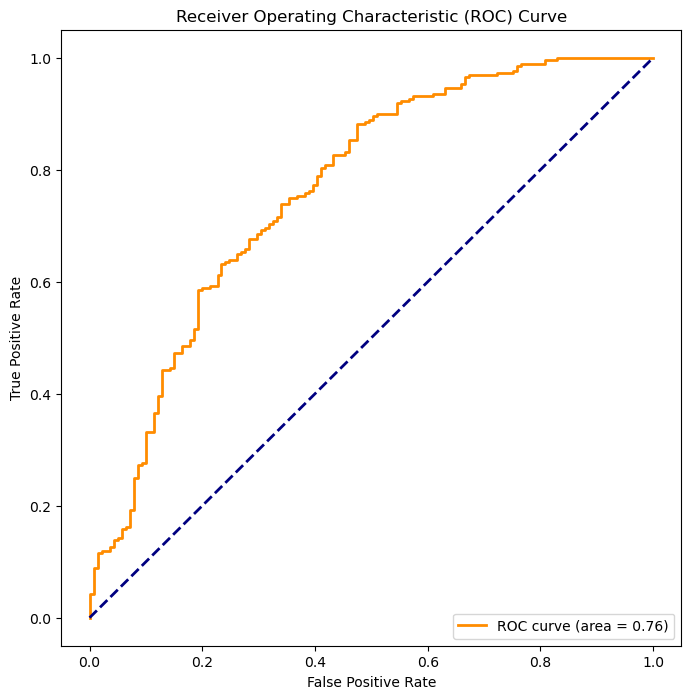

In [1216]:
fpr, tpr, thresholds = roc_curve(y_label, y_pred_proba)
auroc = roc_auc_score(y_label, y_pred_proba)
print("AUROC:", auroc)
#print(y_pred)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()